**KAN: prepare dataset**

In [24]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

X_columns = [
    'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 
    # 'Drate',
    # 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number',
    # 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count',
    # 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
    # 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 
    # 'IPv','LLC', 
    'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
    'Magnitue', 'Radius', 'Covariance',
    # 'Variance', 'Weight'
]

Y_columns = ['label_L1']

label_L1_mapping = {"MQTT": 0, "Benign": 1, "Recon": 2, "ARP_Spoofing": 3}
label_L2_mapping = {"MQTT-DDoS-Connect_Flood": 4, "MQTT-DDoS-Publish_Flood": 5, 
                    "MQTT-DoS-Connect_Flood": 6, "MQTT-DoS-Publish_Flood": 7,
                    "MQTT-Malformed_Data": 8, "benign": 9, 
                    "Recon-OS_Scan": 10, "Recon-Port_Scan": 11,
                    "arp_spoofing": 12}


# Read the CSV file
df = pd.read_csv('/home/zyang44/Github/baseline_cicIOT/CIC_IoMT/19classes/filtered_train_l_4_11.csv')
df['label_L1'] = df['label_L1'].map(label_L1_mapping)
df['label_L2'] = df['label_L2'].map(label_L2_mapping)

# Shuffle the dataframe before splitting into training and test sets
df = df.sample(frac=1, random_state=42)
# 90% as training set and 10% as test set
train_size = int(len(df) * 0.9)
train_df, test_df = df.iloc[:train_size, :], df.iloc[train_size:, :]

scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_df[X_columns])
test_X_scaled = scaler.transform(test_df[X_columns])
train_y = train_df[Y_columns].values.ravel()
test_y = test_df[Y_columns].values.ravel()

# take Y_columns as the label, and transfering to one-hot coded
dataset = {
    'train_input': torch.tensor(train_X_scaled, dtype=torch.float32, device=device),
    'train_label': F.one_hot(torch.tensor(train_y, dtype=torch.long, device=device), num_classes=4),
    'test_input': torch.tensor(test_X_scaled, dtype=torch.float32, device=device),
    'test_label': F.one_hot(torch.tensor(test_y, dtype=torch.long, device=device), num_classes=4)
}
print("Data prepared.",
      f"Train set: {dataset['train_input'].shape, dataset['train_label'].shape}",
      f"Test set: {dataset['test_input'].shape, dataset['test_label'].shape}", sep="\n")

cuda:0
Data prepared.
Train set: (torch.Size([89918, 16]), torch.Size([89918, 4]))
Test set: (torch.Size([9991, 16]), torch.Size([9991, 4]))


**Build myKAN**

A wrapper function, to only get the logits output by the last layer.

In [17]:
import torch.nn as nn

class MultiKANModel(nn.Module):
    def __init__(self, kan):
        """
        Wrap an already built MultKAN instance.
        Args:
            kan: a MultKAN model (which has attributes such as act_fun, symbolic_fun, node_bias, node_scale,
                 subnode_bias, subnode_scale, depth, width, mult_homo, mult_arity, input_id, symbolic_enabled, etc.)
        """
        super(MultiKANModel, self).__init__()
        self.kan = kan

    def forward(self, x, training=False, singularity_avoiding=False, y_th=10.):
        # Select input features according to input_id
        x = x[:, self.kan.input_id.long()]
        # Loop through each layer
        for l in range(self.kan.depth):
            # Get outputs from the numerical branch (KANLayer) of current layer
            x_numerical, preacts, postacts_numerical, postspline = self.kan.act_fun[l](x)
            # Get output from the symbolic branch if enabled
            if self.kan.symbolic_enabled:
                x_symbolic, postacts_symbolic = self.kan.symbolic_fun[l](x, singularity_avoiding=singularity_avoiding, y_th=y_th)
            else:
                x_symbolic = 0.
            # Sum the numerical and symbolic outputs
            x = x_numerical + x_symbolic

            # Subnode affine transformation
            x = self.kan.subnode_scale[l][None, :] * x + self.kan.subnode_bias[l][None, :]

            # Process multiplication nodes
            dim_sum = self.kan.width[l+1][0]
            dim_mult = self.kan.width[l+1][1]
            if dim_mult > 0:
                if self.kan.mult_homo:
                    for i in range(self.kan.mult_arity-1):
                        if i == 0:
                            x_mult = x[:, dim_sum::self.kan.mult_arity] * x[:, dim_sum+1::self.kan.mult_arity]
                        else:
                            x_mult = x_mult * x[:, dim_sum+i+1::self.kan.mult_arity]
                else:
                    for j in range(dim_mult):
                        acml_id = dim_sum + int(np.sum(self.kan.mult_arity[l+1][:j]))
                        for i in range(self.kan.mult_arity[l+1][j]-1):
                            if i == 0:
                                x_mult_j = x[:, [acml_id]] * x[:, [acml_id+1]]
                            else:
                                x_mult_j = x_mult_j * x[:, [acml_id+i+1]]
                        if j == 0:
                            x_mult = x_mult_j
                        else:
                            x_mult = torch.cat([x_mult, x_mult_j], dim=1)
                # Concatenate sum and mult parts
                x = torch.cat([x[:, :dim_sum], x_mult], dim=1)

            # Node affine transformation
            x = self.kan.node_scale[l][None, :] * x + self.kan.node_bias[l][None, :]

        # Final x corresponds to the logits output of the whole model
        return x

**LTN Setting**

In [18]:
import ltn
import ltn.fuzzy_ops

# define the connectives, quantifiers, and the SatAgg
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())   # And = ltn.Connective(custom_fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
SatAgg = ltn.fuzzy_ops.SatAgg()

# define ltn constants
l_MQTT = ltn.Constant(torch.tensor([1, 0, 0, 0]))
l_Benign = ltn.Constant(torch.tensor([0, 1, 0, 0]))
l_Recon = ltn.Constant(torch.tensor([0, 0, 1, 0]))
l_ARP_Spoofing = ltn.Constant(torch.tensor([0, 0, 0, 1]))

In [25]:
from utils import MLP, LogitsToPredicate, DataLoader, DataLoaderMulti
from kan import KAN

# Define the MLP predicate
mlp = MLP(layer_sizes=(16, 10, 4)).to(device)
P_mlp = ltn.Predicate(LogitsToPredicate(mlp))

# Define myKAN predicate
kan = KAN(width=[16, 10, 4], grid=5, k=3, seed=42, device=device)
mykan = MultiKANModel(kan)
P_kan = ltn.Predicate(LogitsToPredicate(mykan))

checkpoint directory created: ./model
saving model version 0.0


**KAN effect**

LTN(kan) v.s LTN(mlp)

In [26]:
# Define the DataLoader adapted to the LTN input format. 'data' is same, 'labels' is numeric (not one-hot)
train_loader = DataLoader(data=dataset['train_input'], labels=torch.tensor(train_y, dtype=torch.long, device=device), batch_size=len(dataset['train_input']))
test_loader = DataLoader(data=dataset['test_input'], labels=torch.tensor(test_y, dtype=torch.long, device=device), batch_size=len(dataset['test_input']))

# filter the data by label_L1, data is a tensor(n*20), label_L1 is a tensor(n*4)
# based on the label_L1, we store the data into different ltn.Variable
def compute_sat_levels(loader, P):
	sat_level  = 0
	for data, labels in loader:
		x = ltn.Variable("x", data)
		x_MQTT = ltn.Variable("x_MQTT", data[labels == 0])
		x_Benign = ltn.Variable("x_Benign", data[labels == 1])
		x_Recon = ltn.Variable("x_Recon", data[labels == 2])
		x_ARP_Spoofing = ltn.Variable("x_ARP_Spoofing", data[labels == 3])
		
		sat_level = SatAgg(
			Forall(x_MQTT, P(x_MQTT, l_MQTT)),
			Forall(x_Benign, P(x_Benign, l_Benign)),
			Forall(x_Recon, P(x_Recon, l_Recon)),
			Forall(x_ARP_Spoofing, P(x_ARP_Spoofing, l_ARP_Spoofing))
		)
	return sat_level


def compute_accuracy(loader, model):
    total_correct = 0
    total_samples = 0
    for data, labels in loader:
        logits = model(data)
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == labels).sum()
        total_samples += labels.numel()
    return total_correct.float() / total_samples
    

optimizer_mlp = torch.optim.Adam(P_mlp.parameters(), lr=0.0015)
optimizer_kan = torch.optim.Adam(P_kan.parameters(), lr=0.0015)

for epoch in range(301):
	# Train the MLP
    optimizer_mlp.zero_grad()
    sat_mlp = compute_sat_levels(train_loader, P_mlp)
    loss = 1. - sat_mlp
    loss.backward()
    optimizer_mlp.step()
    train_loss_mlp  = loss.item()

    # Train the KAN
    optimizer_kan.zero_grad()
    sat_kan = compute_sat_levels(train_loader, P_kan)
    loss = 1. - sat_kan
    loss.backward()
    optimizer_kan.step()
    train_loss_kan = loss.item()
	
    # Test
    acc_mlp = compute_accuracy(test_loader, mlp)
    acc_kan = compute_accuracy(test_loader, kan)

    test_sat_mlp = compute_sat_levels(test_loader, P_mlp)
    test_sat_kan = compute_sat_levels(test_loader, P_kan)

    print(f"Epoch {epoch} | MLP (loss/acc/sat): {train_loss_mlp:.3f}/{acc_mlp:.3f}/{sat_mlp:.3f}({test_sat_mlp:.3f}) | KAN (loss/acc/sat): {train_loss_kan:.3f}/{acc_kan:.3f}/{sat_kan:.3f}({test_sat_kan:.3f})")

Epoch 0 | MLP (loss/acc/sat): 0.742/0.421/0.258(0.259) | KAN (loss/acc/sat): 0.766/0.201/0.234(0.236)
Epoch 1 | MLP (loss/acc/sat): 0.741/0.473/0.259(0.260) | KAN (loss/acc/sat): 0.765/0.231/0.235(0.237)
Epoch 2 | MLP (loss/acc/sat): 0.740/0.489/0.260(0.261) | KAN (loss/acc/sat): 0.763/0.242/0.237(0.239)
Epoch 3 | MLP (loss/acc/sat): 0.739/0.492/0.261(0.262) | KAN (loss/acc/sat): 0.762/0.247/0.238(0.240)
Epoch 4 | MLP (loss/acc/sat): 0.738/0.496/0.262(0.263) | KAN (loss/acc/sat): 0.760/0.250/0.240(0.241)
Epoch 5 | MLP (loss/acc/sat): 0.737/0.506/0.263(0.265) | KAN (loss/acc/sat): 0.759/0.256/0.241(0.243)
Epoch 6 | MLP (loss/acc/sat): 0.736/0.537/0.264(0.266) | KAN (loss/acc/sat): 0.758/0.260/0.242(0.244)
Epoch 7 | MLP (loss/acc/sat): 0.734/0.546/0.266(0.267) | KAN (loss/acc/sat): 0.756/0.268/0.244(0.246)
Epoch 8 | MLP (loss/acc/sat): 0.733/0.580/0.267(0.268) | KAN (loss/acc/sat): 0.755/0.274/0.245(0.247)
Epoch 9 | MLP (loss/acc/sat): 0.732/0.563/0.268(0.269) | KAN (loss/acc/sat): 0.753

Key observation:
* [Convergence] loss converge faster. 
* [SAT] the overall Sat level higher, means that it converges along with the rules satisfied well.
* [Acc] accuracy converge eariler, and slightly better at the end.


**Plot**

1. After KAN filter out 2 features, compare 18-feature vs 16-features

In [12]:
plt_config = {
    '20': {'color': '#025492', 'marker': 'o'},
    '18': {'color': '#fad02c', 'marker': 's'},
    '16': {'color': '#1dc690', 'marker': 'D'}
}

line_type = {
    'kan': {'linestyle': '-', 'linewidth': 2},
    'mlp': {'linestyle': '--', 'linewidth': 2}
}

font_size = 28
font_size_axis = 22
line_width = 1

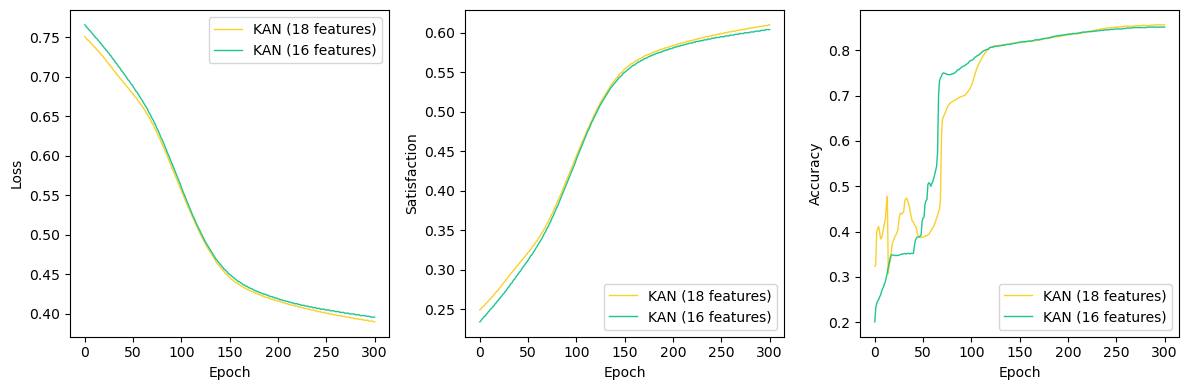

In [ ]:
import re

def parse_feature_file(filename):
    """
    Reads a file with lines of the format:
    
    Epoch X | MLP (loss/acc/sat): train_loss/test_acc/train_sat(test_sat) | KAN (loss/acc/sat): train_loss/test_acc/train_sat(test_sat)
    
    and returns two dictionaries: one for MLP and one for KAN.
    
    Each dictionary has the following keys:
        - "train_loss": list of training loss values,
        - "test_acc": list of test accuracy values,
        - "train_sat": list of training satisfaction values,
        - "test_sat": list of test satisfaction values.
    
    Args:
        filename (str): path to the file

    Returns:
        mlp_info (dict): dictionary of metrics for MLP
        kan_info (dict): dictionary of metrics for KAN
    """
    # Initialize dictionaries with lists
    mlp_info = {"train_loss": [], "test_acc": [], "train_sat": [], "test_sat": []}
    kan_info = {"train_loss": [], "test_acc": [], "train_sat": [], "test_sat": []}
    
    # Regex pattern to capture four numbers after a colon.
    # This is designed to match patterns like: ": 0.724/0.356/0.276(0.278)"
    pattern = r":\s*([\d\.]+)/([\d\.]+)/([\d\.]+)\(([\d\.]+)\)"
    
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if not line or "Epoch" not in line:
                continue
            # Split the line by pipe (|) symbol.
            parts = line.split("|")
            if len(parts) < 3:
                continue
            
            # parts[1] contains MLP metrics and parts[2] contains KAN metrics.
            mlp_part = parts[1]
            kan_part = parts[2]
            
            match_mlp = re.search(pattern, mlp_part)
            match_kan = re.search(pattern, kan_part)
            
            if match_mlp:
                # According to your convention (example):
                # group(1): train_loss, group(2): test_acc, group(3): train_sat, group(4): test_sat
                mlp_info["train_loss"].append(float(match_mlp.group(1)))
                mlp_info["test_acc"].append(float(match_mlp.group(2)))
                mlp_info["train_sat"].append(float(match_mlp.group(3)))
                mlp_info["test_sat"].append(float(match_mlp.group(4)))
                
            if match_kan:
                kan_info["train_loss"].append(float(match_kan.group(1)))
                kan_info["test_acc"].append(float(match_kan.group(2)))
                kan_info["train_sat"].append(float(match_kan.group(3)))
                kan_info["test_sat"].append(float(match_kan.group(4)))
                
    return mlp_info, kan_info

mlp_20, kan_20 = parse_feature_file("20features.txt")
mlp_18, kan_18 = parse_feature_file("18features.txt")
mlp_16, kan_16 = parse_feature_file("16features.txt")

# Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(kan_18["train_loss"], label="KAN (18 features)", color=plt_config['18']['color'], linestyle=line_type['kan']['linestyle'], linewidth=line_width)
plt.plot(kan_16["train_loss"], label="KAN (16 features)", color=plt_config['16']['color'], linestyle=line_type['kan']['linestyle'], linewidth=line_width)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 3, 3)
plt.plot(kan_18["test_acc"], label="KAN (18 features)", color=plt_config['18']['color'], linestyle=line_type['kan']['linestyle'], linewidth=line_width)
plt.plot(kan_16["test_acc"], label="KAN (16 features)", color=plt_config['16']['color'], linestyle=line_type['kan']['linestyle'], linewidth=line_width)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# SAT
plt.subplot(1, 3, 2)
plt.plot(kan_18["train_sat"], label="KAN (18 features)", color=plt_config['18']['color'], linestyle=line_type['kan']['linestyle'], linewidth=line_width)
plt.plot(kan_16["train_sat"], label="KAN (16 features)", color=plt_config['16']['color'], linestyle=line_type['kan']['linestyle'], linewidth=line_width)
plt.xlabel("Epoch")
plt.ylabel("Satisfaction")
plt.legend()

plt.tight_layout()
plt.show()


/tmp/ipykernel_726812/155263543.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


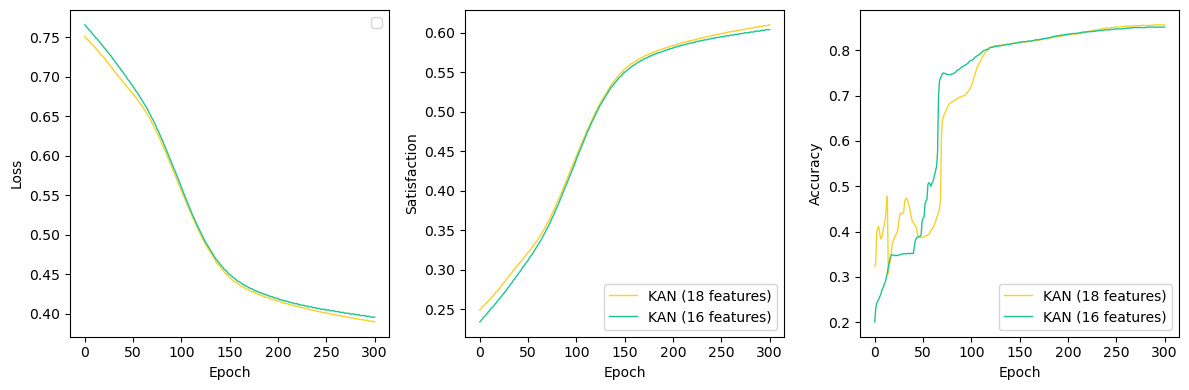

In [31]:
# Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(kan_18["train_loss"], color=plt_config['18']['color'], linestyle=line_type['kan']['linestyle'], linewidth=line_width)
plt.plot(kan_16["train_loss"], color=plt_config['16']['color'], linestyle=line_type['kan']['linestyle'], linewidth=line_width)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 3, 3)
plt.plot(kan_18["test_acc"], label="KAN (18 features)", color=plt_config['18']['color'], linestyle=line_type['kan']['linestyle'], linewidth=line_width)
plt.plot(kan_16["test_acc"], label="KAN (16 features)", color=plt_config['16']['color'], linestyle=line_type['kan']['linestyle'], linewidth=line_width)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# SAT
plt.subplot(1, 3, 2)
plt.plot(kan_18["train_sat"], label="KAN (18 features)", color=plt_config['18']['color'], linestyle=line_type['kan']['linestyle'], linewidth=line_width)
plt.plot(kan_16["train_sat"], label="KAN (16 features)", color=plt_config['16']['color'], linestyle=line_type['kan']['linestyle'], linewidth=line_width)
plt.xlabel("Epoch")
plt.ylabel("Satisfaction")
plt.legend()

plt.tight_layout()
plt.show()